# Импорты + функция для графиков


In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
# Красивый строитель графиков
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

# Скачиваем датасет

Скачаем датасет и посмотрим, что лежит внутри

In [3]:
train_set = CIFAR10(root='./data', train=True, download=True)
test_set = CIFAR10(root='./data', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print('train lenght: ', len(train_set))
print('test lenght: ', len(test_set))
out = train_set[1000]
image, label = out
print('image size: ', image.size)

train lenght:  50000
test lenght:  10000
image size:  (32, 32)


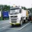

In [5]:
image

In [6]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

А теперь скачаем датасет уже не как много картинок, а как много тензоров, кодирующих картинки

In [7]:
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# если просто использовать T.ToTensor в качестве транстформера, то не получается
# насколько я понял прикол в том, что в CIFAR10 пиксели кодируются только положительными 
# [0, 1] числами, а мы хотим, чтобы они были из промежутка [-1,1]
# это догадки, функцию взял с из туториала с сайта торча

train_set = CIFAR10(root='./data', transform=transform, train=True, download=True)
test_set = CIFAR10(root='./data', transform=transform, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [9]:
for images, labels in train_loader:
  print(images.shape, labels.shape)
  break

torch.Size([64, 3, 32, 32]) torch.Size([64])


# База - 3 линейных слоя с relu + SGD, Adam

In [ ]:
def train():
  train_losses, train_accuracies = [], []
  test_losses, test_accuracies = [], []

  for epoch in range(1, kEpochs + 1):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc='trianing'):

      optimizer.zero_grad() # нужно занулить значения градиентов
      logits = model(torch.flatten(images, 1)) # вытягиваем в вектор-строку
      loss = criterion(logits, labels) # тензор из одного числа - просто результат работы функции потерь
      loss.backward() # считаем градиенты
      optimizer.step()
      
      train_loss += loss.item() * images.shape[0] # у нас же целый батч картинок
      train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]

    if scheduler is not None:
      scheduler.step()

    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc='testing'):

      with torch.no_grad():
        logits = model(torch.flatten(images, 1)) # вытягиваем в вектор-строку
        loss = criterion(logits, labels) # тензор из одного числа - просто результат работы функции потерь
      
      test_loss += loss.item() * images.shape[0] # у нас же целый батч картинок
      test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, num_classes, hidden_size):
    super().__init__()
    self.model = nn.Sequential (
        # в линейные слои можно вставлять параметр bias=False
        # суть в чем - изначально в каждом линейном слое есть какая-то матрица весов,
        # означающая, с какой точки при помощи градиента мы будем двигаться к впадине
        # насколько я понимаю если bias=False, то мы просто начинаем движение с нуля???
        nn.Linear(in_features=in_features, out_features=hidden_size),
        nn.ReLU(),
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.ReLU(),
        nn.Linear(in_features=hidden_size, out_features=num_classes),
    )
  
  def forward(self, x):
    return self.model(x)

10 Эпох, оптимизировал с SGD

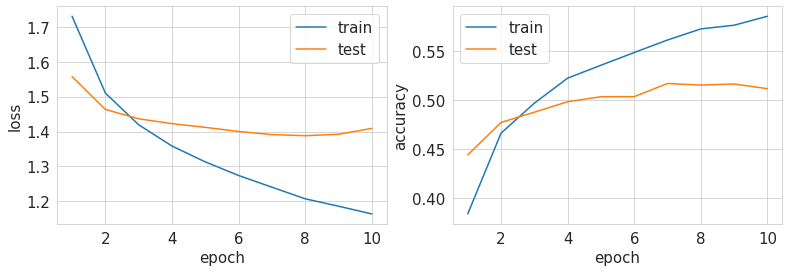

In [ ]:
kImgSize = 32
kNumClasses = 10
kHiddenSize = 64
kChannels = 3
kEpochs = 10

model = MLP(in_features=kImgSize ** 2 * kChannels, num_classes=kNumClasses, hidden_size=kHiddenSize)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = None
criterion = nn.CrossEntropyLoss()
train()

10 Эпох, оптимизировал с Адамом без wd

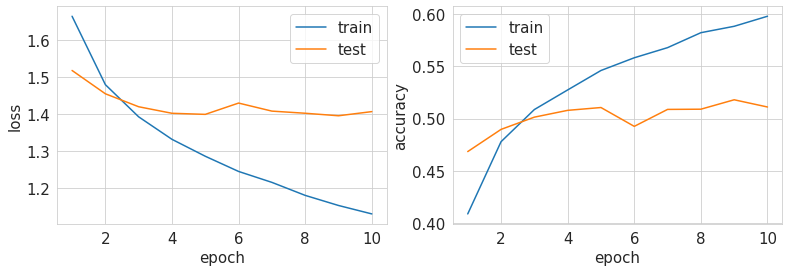

In [ ]:
kImgSize = 32
kNumClasses = 10
kHiddenSize = 64
kChannels = 3
kEpochs = 10

model = MLP(in_features=kImgSize ** 2 * kChannels, num_classes=kNumClasses, hidden_size=kHiddenSize)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = None
criterion = nn.CrossEntropyLoss()
train()

10 Эпох, оптимизировал с Адамом c wd

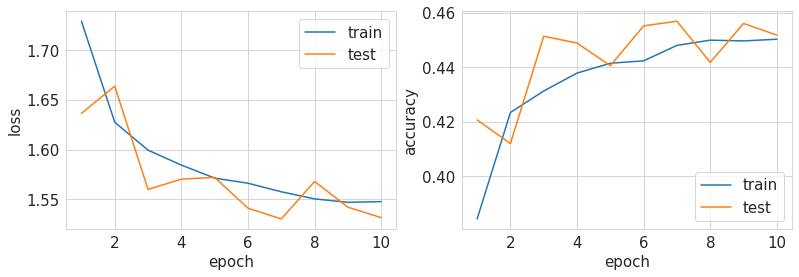

In [ ]:
kImgSize = 32
kNumClasses = 10
kHiddenSize = 64
kChannels = 3
kEpochs = 10

model = MLP(in_features=kImgSize ** 2 * kChannels, num_classes=kNumClasses, hidden_size=kHiddenSize)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = None
criterion = nn.CrossEntropyLoss()
train()

10 Эпох, Адам без wd + допавил scheduler

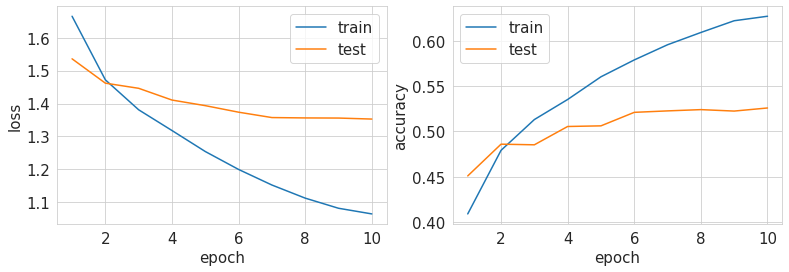

In [ ]:
kImgSize = 32
kNumClasses = 10
kHiddenSize = 64
kChannels = 3
kEpochs = 10

model = MLP(in_features=kImgSize ** 2 * kChannels, num_classes=kNumClasses, hidden_size=kHiddenSize)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

10 Эпох, SGD + scheduler

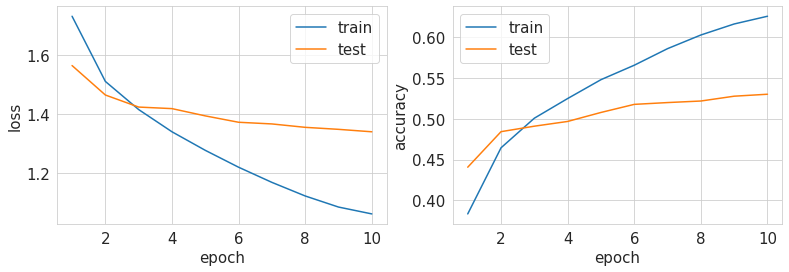

In [ ]:
kImgSize = 32
kNumClasses = 10
kHiddenSize = 64
kChannels = 3
kEpochs = 10

model = MLP(in_features=kImgSize ** 2 * kChannels, num_classes=kNumClasses, hidden_size=kHiddenSize)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

# Шоу импровизация

Добавил dropout и еще 2 линейных слоя, поменял величины слоев

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, num_classes, hidden_size):
    super().__init__()
    self.model = nn.Sequential (
        # в линейные слои можно вставлять параметр bias=False
        # суть в чем - изначально в каждом линейном слое есть какая-то матрица весов,
        # означающая, с какой точки при помощи градиента мы будем двигаться к впадине
        # насколько я понимаю если bias=False, то мы просто начинаем движение с нуля???
        nn.Linear(in_features=in_features, out_features=32),
        nn.LeakyReLU(0.1),
        nn.Linear(in_features=32, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=64),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.25),
        nn.Linear(in_features=64, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=num_classes),
    )
  
  def forward(self, x):
    return self.model(x)

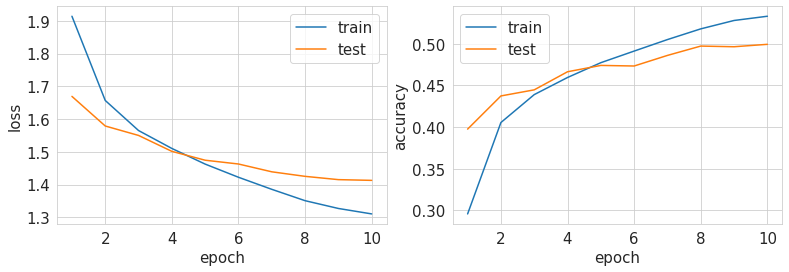

In [ ]:
kImgSize = 32
kNumClasses = 10
kHiddenSize = 64
kChannels = 3
kEpochs = 10

model = MLP(in_features=kImgSize ** 2 * kChannels, num_classes=kNumClasses, hidden_size=kHiddenSize)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

 Попробуем добавить еще одни dropuot

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, num_classes, hidden_size):
    super().__init__()
    self.model = nn.Sequential (
        # в линейные слои можно вставлять параметр bias=False
        # суть в чем - изначально в каждом линейном слое есть какая-то матрица весов,
        # означающая, с какой точки при помощи градиента мы будем двигаться к впадине
        # насколько я понимаю если bias=False, то мы просто начинаем движение с нуля???
        nn.Linear(in_features=in_features, out_features=32),
        nn.LeakyReLU(0.1),
        nn.Linear(in_features=32, out_features=16),
        nn.ReLU(),
        nn.Dropout(p=0.25),
        nn.Linear(in_features=16, out_features=64),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.25),
        nn.Linear(in_features=64, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=num_classes),
    )
  
  def forward(self, x):
    return self.model(x)

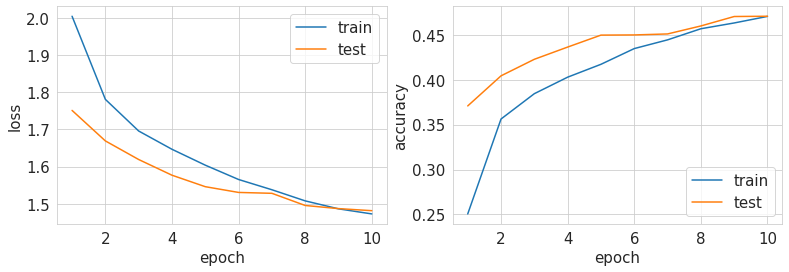

In [ ]:
kImgSize = 32
kNumClasses = 10
kHiddenSize = 64
kChannels = 3
kEpochs = 10

model = MLP(in_features=kImgSize ** 2 * kChannels, num_classes=kNumClasses, hidden_size=kHiddenSize)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

# Оказалось что сверточные слои тоже можно использовать

In [14]:
# единственное отличие заключается в том, что теперь картинки не нужно вытягивать в вектор
def train():
  train_losses, train_accuracies = [], []
  test_losses, test_accuracies = [], []

  for epoch in range(1, kEpochs + 1):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc='trianing'):
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # нужно занулить значения градиентов
      logits = model(images)
      loss = criterion(logits, labels) # тензор из одного числа - просто результат работы функции потерь
      loss.backward() # считаем градиенты
      optimizer.step()
      
      train_loss += loss.item() * images.shape[0] # у нас же целый батч картинок
      train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]

    if scheduler is not None:
      scheduler.step()

    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc='testing'):
      images = images.to(device)
      labels = labels.to(device)

      with torch.no_grad():
        logits = model(images)
        loss = criterion(logits, labels) # тензор из одного числа - просто результат работы функции потерь
      
      test_loss += loss.item() * images.shape[0] # у нас же целый батч картинок
      test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
    print('train loss: ', train_loss)
    print('test loss: ', test_loss)
    print('train_accuracy: ', train_accuracy)
    print('test_accuracy: ', test_accuracy)

## LeNet5

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, image_channels, out_features):
        super().__init__()
        # принято рабивать слои на сверточные и на голову, 
        # в которой 1-2 линейных слоя для перехода к нужным размерностям
        self.encoder = nn.Sequential(  # 32 x 32
            nn.Conv2d(in_channels=image_channels, out_channels=6, kernel_size=5),  # 28 x 28
            nn.Tanh(),
            nn.AvgPool2d(2),  # 14 x 14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),  # 10 x 10
            nn.Tanh(),
            nn.AvgPool2d(2),  # 5 x 5
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)  # 1 x 1
        )
        
        self.head = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=out_features)
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = out.squeeze(-1).squeeze(-1)
        out = self.head(out)
        return out

20 Эпох, SGD

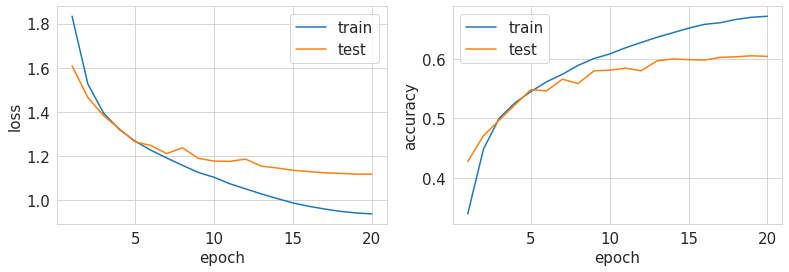

train loss:  0.9379512747383117
test loss:  1.1178452463150024
train_accuracy:  0.67214
test_accuracy:  0.6045


In [ ]:
kNumClasses = 10
kChannels = 3
kEpochs = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LeNet5(kChannels, kNumClasses).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

Результат растет и это радует!!!




## AlexNet


In [ ]:
transform= T.Compose(
    [   T.Resize(256),
     T.RandomHorizontalFlip(),
    T.ToTensor(),
     T.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223 , 0.24348513, 0.26158784])
    ])

# спустя день в одном из туториалов увидел, что для тестовой выборки
# делают отдельный transform, ибо зачем нам добавлять аугментации в тест. 
# Но решил уже не менять тут, чтобы не перезапускать AlexNet, хотя вероятно это улучшило бы скор

train_set = CIFAR10(root='./data', transform=transform, train=True, download=True)
test_set = CIFAR10(root='./data', transform=transform, train=False, download=True)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, image_channels, out_features):
        super().__init__()
        self.features= nn.Sequential(
        nn.Conv2d(image_channels, 96, kernel_size=11, stride=4, padding=0),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        #2
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        #3
        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #4
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #5
        nn.Conv2d(384, 256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool= nn.AvgPool2d(6)
        self.classifier= nn.Sequential(
            nn.Dropout(), nn.Linear(256*6*6, 4096), #128*2*2, 1024
        nn.ReLU(inplace=True), nn.Dropout(),
        nn.Linear(4096, out_features=out_features)
        )
    
    def forward(self, x):
        x= self.features(x)
        x=x.view(x.size(0), 256*6*6)
        x= self.classifier(x)
        return x



In [ ]:
# вот эта хреновина обучается реально долго, попробую подключить gpu

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


10 Эпох + Адам

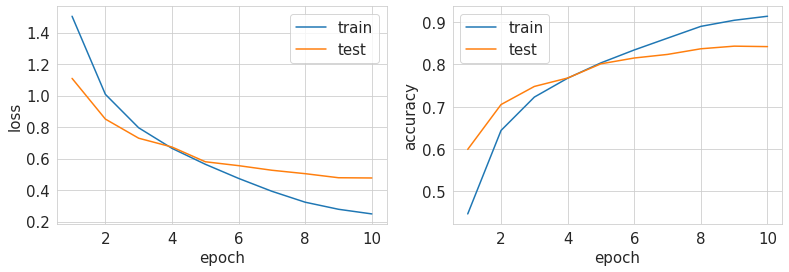

In [ ]:
kNumClasses = 10
kChannels = 3
kEpochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AlexNet(kChannels, kNumClasses).to(device)
optimizer= torch.optim.Adam(params= model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

Модель ну оооочень тяжелая, в ней где-то 60 миллионов весов. Это очень много, зато скор неплохой получилось выбить. Думаю если сделать побольше эпох, то он еще подрастет, но в 95% не вериться, поэтому дальше хочу сделать SimpleNet. Так много достаточно простых и лекговесных слоев, но ребята заявляют, что она способна выбить внушающий скор

Пока ездил на военку сделал побольше эпох. Результат и вправду улучился, добавил вывод итоговых статистик в ответ, чтобы не только по графикам смотреть

25 Эпох + Адам

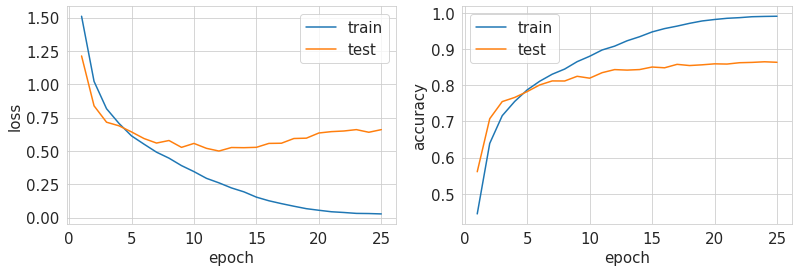

train loss:  0.0280342877997458
test loss:  0.659663144826889
train_accuracy:  0.99058
test_accuracy:  0.8634


In [ ]:
kNumClasses = 10
kChannels = 3
kEpochs = 25

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AlexNet(kChannels, kNumClasses).to(device)
optimizer= torch.optim.Adam(params= model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

## ResNet34


Сначала наткнулся на сайте paperswithcode на модель SimpleNet, но не успел ее реализовать

Меня занесло посмотреть лекцию, послушал там про ResNet, она предельно похожа на SimpleNet своей простотой блоков, но в ней используется residual блоки, что очень хочется реализовать ручками и посмотреть как оно работает. По сути должно работать лучше, чем SimpleNet, как раз таки в силу этих новых блоков, которые помогают предотвратить затухание градиентов
Показалось, что 34 слойной resnet должно хватить, давайте проверим:



In [10]:
class Block(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False) # добавляем паддинги, чтобы размер не менялся при свертке матричкой 3*3
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        # а если размерность или число каналов поменялось, то нам нужно 
        # пропустить предыдущий блок через изменитель размерности и кол-ва каналов
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.nn.functional.relu(out)
        return out


In [11]:

class ResNet34(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet34, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

10 Эпох + Адам

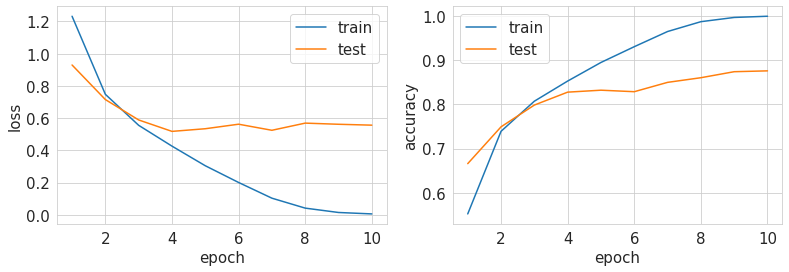

train loss:  0.0058801563250087206
test loss:  0.5566601277828217
train_accuracy:  0.99914
test_accuracy:  0.8757


In [ ]:
kNumClasses = 10
kChannels = 3
kEpochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet34(kNumClasses).to(device)
optimizer= torch.optim.Adam(params= model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

10 Эпох + SGD с wd=1e-5

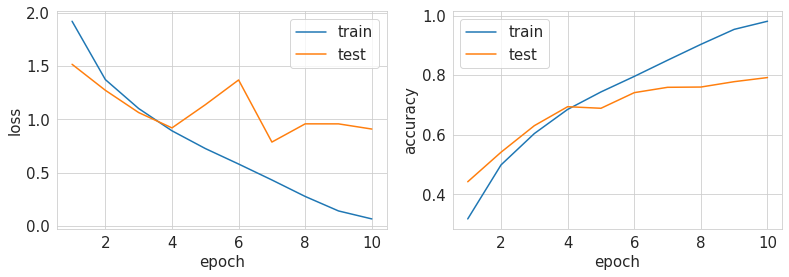

train loss:  0.06404541214108467
test loss:  0.9090613447189331
train_accuracy:  0.98082
test_accuracy:  0.792


In [ ]:
kNumClasses = 10
kChannels = 3
kEpochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet34(kNumClasses).to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.05, momentum=0.9,weight_decay=1e-5) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

10 Эпох + SGD с wd=1e-2

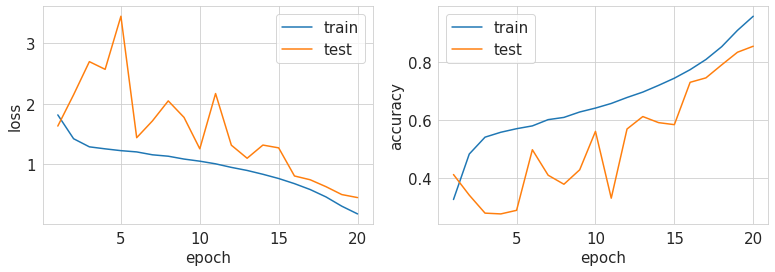

train loss:  0.17485127946853637
test loss:  0.4455590954780579
train_accuracy:  0.95878
test_accuracy:  0.8552


In [ ]:
kNumClasses = 10
kChannels = 3
kEpochs = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet34(kNumClasses).to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.05, momentum=0.9,weight_decay=1e-2) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

30 Эпох + Адам

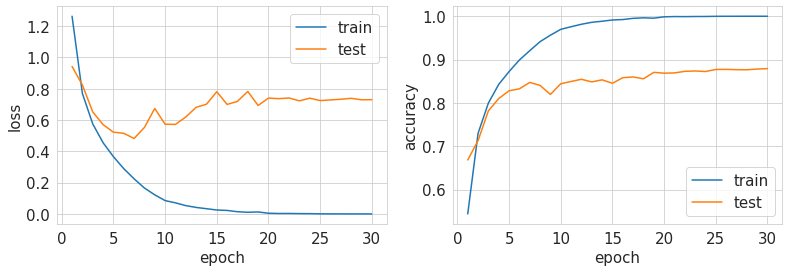

train loss:  0.00012746689625520958
test loss:  0.7302372837066651
train_accuracy:  1.0
test_accuracy:  0.8791


In [ ]:
kNumClasses = 10
kChannels = 3
kEpochs = 30

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet34(kNumClasses).to(device)
optimizer= torch.optim.Adam(params= model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

Теперь хочется добавить аугментаций, потому что в моем понимании они должны немного уменьшить разнообразить тренировочную выборку, что поможет добиться лучшего скора

In [12]:
transform_train = T.Compose([
  T.RandomCrop(32, padding=4),  
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = T.Compose([ #                
  T.ToTensor(),
  T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = CIFAR10(root='./data', transform=transform, train=True, download=True)
test_set = CIFAR10(root='./data', transform=transform, train=False, download=True)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


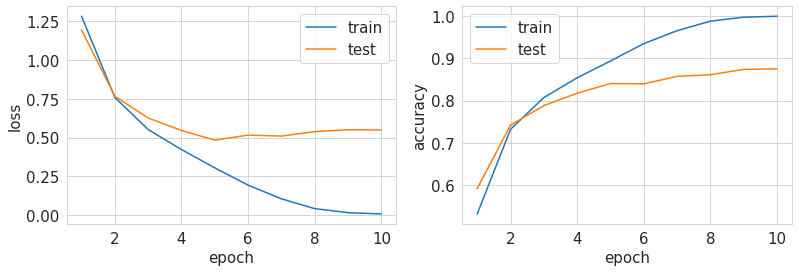

train loss:  0.006746585234850645
test loss:  0.5489162214279175
train_accuracy:  0.99864
test_accuracy:  0.8747


In [ ]:
kNumClasses = 10
kChannels = 3
kEpochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet34(kNumClasses).to(device)
optimizer= torch.optim.Adam(params= model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kEpochs)
criterion = nn.CrossEntropyLoss()
train()

Коллаб сказал, что лимит GPU исчерпан :(